In [1]:
from pathlib import Path

import graphviz
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import tree

In [2]:
PATH = Path("results/prunned_tree")
PATH.mkdir(exist_ok=True)

In [3]:
df = pd.read_csv("data/final_train.csv", index_col=0)
df.head()

Activity  angle(X,gravityMean)  angle(Y,gravityMean)  \
0          STANDING             -1.574191             -0.805700   
1  WALKING_UPSTAIRS             -1.568669             -0.612620   
2            LAYING             -1.548333             -0.139628   
3           WALKING             -1.574094             -0.793443   
4            LAYING             -1.548333             -0.139628   

   angle(Z,gravityMean)  angle(tBodyAccJerkMean),gravityMean)  \
0             -2.453831                             -1.861714   
1             -2.488338                             -1.751117   
2             -2.380889                             -1.915239   
3             -2.449959                             -1.842741   
4             -2.380889                                   NaN   

   angle(tBodyAccMean,gravity)  angle(tBodyGyroJerkMean,gravityMean)  \
0                     0.115517                             -2.023369   
1                     0.218134                              0.280294   
2                     0.067613                             -0.887342   
3                    -0.195625                             -0.950671   
4                     0.067613                             -0.887342   

   angle(tBodyGyroMean,gravityMean)  energy-mean()  \
0                          3.125860      -9.474436   
1                          7.953403      -0.679894   
2                          6.007361     -11.906904   
3                          2.104353     -11.906121   
4                          6.007361     -11.970485   

   fBodyAcc-bandsEnergy()-1,16  ...  tGravityAccMag-energy()  \
0                     3.622600  ...                 5.049130   
1                     2.512880  ...                 4.565443   
2                     3.621984  ...                 5.059609   
3                     3.355701  ...                 4.860758   
4                     3.621984  ...                 5.059609   

   tGravityAccMag-entropy()  tGravityAccMag-iqr()  tGravityAccMag-mad()  \
0                  3.272281              5.103018             -0.823302   
1                  4.440779              3.288399             -2.689605   
2                  2.296603              5.344174             -0.549843   
3                  4.177535              3.950012             -0.322642   
4                  2.296603              5.344174             -0.549843   

   tGravityAccMag-max()  tGravityAccMag-mean()  tGravityAccMag-min()  \
0              3.063681              -0.928676             -1.007695   
1              1.705341              -0.822617             -0.572410   
2              3.272225              -0.940610             -1.031522   
3              2.366287              -0.866937             -0.696431   
4              3.272225              -0.940610             -1.031522   

   tGravityAccMag-sma()  tGravityAccMag-std()  void()  
0              3.094236              1.669987     1.0  
1             -2.187890             -0.544652     2.0  
2             -2.071755              2.024442     3.0  
3              1.863375              0.550414     2.0  
4             -2.102513              2.024442     3.0  

[5 rows x 572 columns]

# Data preprocessing

In [4]:
df = df.drop(columns=["subject", "void()"])
df = df.dropna()

In [5]:
y = df["Activity"]
X = df.drop(columns=["Activity"])

# Loading prunned tree

In [6]:
prunned_tree_clf = joblib.load("results/prunned_tree/prunned_tree.joblib")

# Visualisation

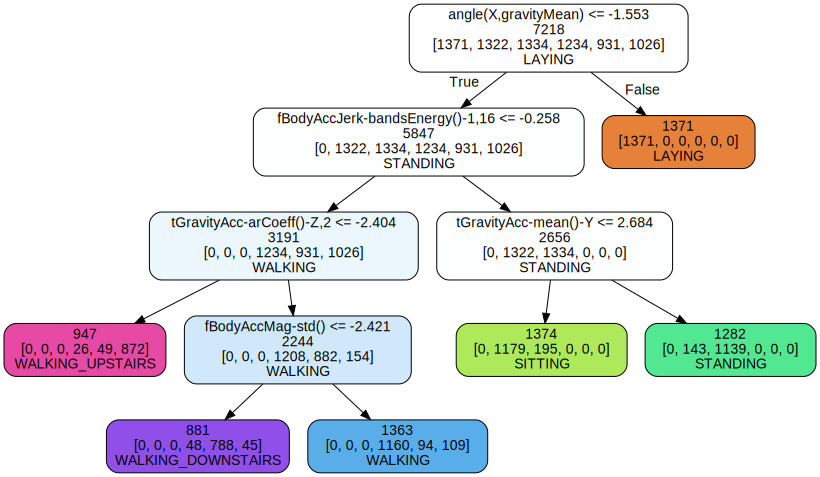

In [7]:
dot_data = tree.export_graphviz(
    prunned_tree_clf,
    feature_names=X.columns,
    class_names=prunned_tree_clf.classes_,
    label="none",
    filled=True,
    impurity=False,
    rounded=True
)
graph = graphviz.Source(dot_data)
graph

# Explaination

## 1. LAYING / NOT LAYING

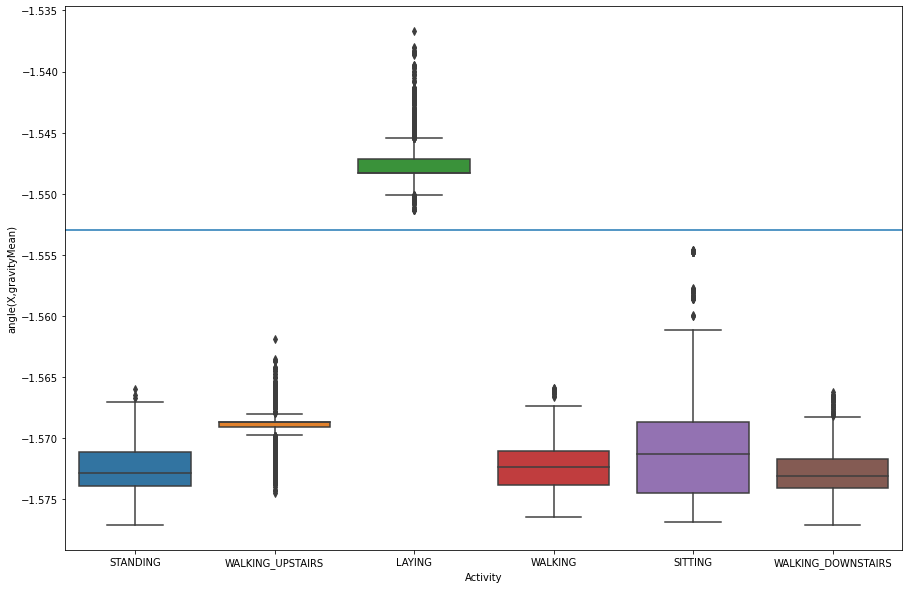

In [8]:
laying_feature = X.columns[prunned_tree_clf.tree_.feature[0]]
laying_threshold = prunned_tree_clf.tree_.threshold[0]

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(y=laying_feature, x=df["Activity"], data=X, ax=ax)
ax.hlines(laying_threshold, *ax.get_xlim())

plt.show()

# 2. Second split

In [9]:
second_df = df[X[laying_feature] <= laying_threshold]

In [10]:
second_feature = X.columns[prunned_tree_clf.tree_.feature[1]]
second_threshold = prunned_tree_clf.tree_.threshold[1]

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(y=second_feature, x="Activity", data=second_df, ax=ax)
ax.hlines(second_threshold, *ax.get_xlim())

plt.show()

## 3. SITTING / STANDING

In [11]:
sit_stand_df = second_df[second_df[second_feature] > second_threshold]

In [12]:
feature = X.columns[prunned_tree_clf.tree_.feature[7]]
threshold = prunned_tree_clf.tree_.threshold[7]

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(y=feature, x="Activity", data=sit_stand_df, ax=ax)
ax.hlines(threshold, *ax.get_xlim())

plt.show()

## 4. WALKING_UPSTAIRS

In [13]:
walking_all_df = second_df[second_df[second_feature] <= second_threshold]

In [14]:
upstairs_feature = X.columns[prunned_tree_clf.tree_.feature[2]]
upstairs_threshold = prunned_tree_clf.tree_.threshold[2]

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(y=upstairs_feature, x="Activity", data=walking_all_df, ax=ax)
ax.hlines(upstairs_threshold, *ax.get_xlim())

plt.show()

## 5. WALKING / WALKING_DOWNSTAIRS

In [15]:
last_df = walking_all_df[walking_all_df[upstairs_feature] <= upstairs_threshold]

In [16]:
last_feature = X.columns[prunned_tree_clf.tree_.feature[4]]
last_threshold = prunned_tree_clf.tree_.threshold[4]

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(y=last_feature, x="Activity", data=last_df, ax=ax)
ax.hlines(last_threshold, *ax.get_xlim())

plt.show()